In [82]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import OrderedDict

#remove warnings
import warnings
warnings.filterwarnings('ignore')


In [83]:
#get player teams into dataframe from player_teams.csv
player_teams = pd.read_csv('../basketballPlayoffs/players_teams.csv')

#get player teams into dataframe from player_teams.csv
coaches = pd.read_csv('../basketballPlayoffs/coaches.csv')

#teams match up results (only post is available)
series_post = pd.read_csv('../basketballPlayoffs/series_post.csv')

#team stats in playoff
teams_post = pd.read_csv('../basketballPlayoffs/teams_post.csv')

#player csv
players = pd.read_csv('../basketballPlayoffs/players.csv')

#awards csv
awards_players = pd.read_csv('../basketballPlayoffs/awards_players.csv')

#teams csv
teams = pd.read_csv('../basketballPlayoffs/teams.csv')

#remove all columns starting with "lgID" from all dataframes
for df in [player_teams, coaches, series_post, teams_post, players, awards_players, teams]:
    for col in df.columns:
        if col.startswith('lgID'):
            df.drop(col, axis=1, inplace=True)




In [84]:
# Assuming you have a column 'year' to sort by
player_teams = player_teams.sort_values(by=['playerID', 'year'])
player_teams['career_year'] = player_teams.groupby('playerID').cumcount() + 1

def compute_percentage(numerator, denominator):
    return round(numerator.divide(denominator).where(denominator != 0, 0.0)*100,2)

# Regular Season Percentages
player_teams['ft%'] = compute_percentage(player_teams['ftMade'], player_teams['ftAttempted'])
player_teams['fg%'] = compute_percentage(player_teams['fgMade'], player_teams['fgAttempted'])
player_teams['three%'] = compute_percentage(player_teams['threeMade'], player_teams['threeAttempted'])
player_teams['gs%'] = compute_percentage(player_teams['GS'], player_teams['GP'])

# Playoffs Percentages
player_teams['Postft%'] = compute_percentage(player_teams['PostftMade'], player_teams['PostftAttempted'])
player_teams['Postfg%'] = compute_percentage(player_teams['PostfgMade'], player_teams['PostfgAttempted'])
player_teams['Postthree%'] = compute_percentage(player_teams['PostthreeMade'], player_teams['PostthreeAttempted'])
player_teams['Postgs%'] = compute_percentage(player_teams['PostGS'], player_teams['PostGP'])

#remove the made and attempted columns
player_teams.drop(['ftMade', 'ftAttempted', 'fgMade', 'fgAttempted', 'threeMade', 'threeAttempted', 'PostftMade', 'PostftAttempted', 'PostfgMade', 'PostfgAttempted', 'PostthreeMade', 'PostthreeAttempted', 'PostGS', 'PostGP'], axis=1, inplace=True)


player_teams.head()

,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostDQ,career_year,ft%,fg%,three%,gs%,Postft%,Postfg%,Postthree%,Postgs%
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,0,1,72.73,38.91,25.00,88.46,0.0,0.00,0.00,0.0
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,0,2,48.28,37.66,33.33,100.00,0.0,0.00,0.00,0.0
2,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,0,3,70.41,39.30,30.49,83.33,100.0,27.27,42.86,100.0
3,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,0,4,60.87,35.25,37.74,50.00,50.0,34.78,25.00,100.0
4,abrossv01w,6,0,MIN,31,31,777,304,29,78,...,0,5,72.60,39.49,40.24,100.00,0.0,0.00,0.00,0.0


In [85]:
coaches['total_games'] = coaches['won']+ coaches['lost']
coaches['W%'] = compute_percentage(coaches['won'],coaches['total_games'])

coaches['total_p_games'] = coaches['post_wins']+ coaches['post_losses']
coaches['postW%'] = compute_percentage(coaches['post_wins'],coaches['total_p_games'])

#remove won and lost columns, and post_wins and post_losses
coaches.drop(['won','lost','post_wins','post_losses'], axis=1, inplace=True)

coaches.head()

,coachID,year,tmID,stint,total_games,W%,total_p_games,postW%
0,adamsmi01w,5,WAS,0,34,50.00,3,33.33
1,adubari99w,1,NYL,0,32,62.50,7,57.14
2,adubari99w,2,NYL,0,32,65.62,6,50.00
3,adubari99w,3,NYL,0,32,56.25,8,50.00
4,adubari99w,4,NYL,0,34,47.06,0,0.00


In [86]:
# Get all unique teams
unique_teams = set(series_post['tmIDWinner']).union(series_post['tmIDLoser'])

# Create all possible combinations of matchups (excluding self-matchups)
matchups = combinations(sorted(unique_teams), 2)

# Initialize the records for all matchups
records = OrderedDict(((team1, team2), {'t1winsvst2': 0, 't1lossesvst2': 0}) for team1, team2 in matchups)

# Update win-loss counts
for _, row in series_post.iterrows():
    winner, loser = row['tmIDWinner'], row['tmIDLoser']
    
    if (winner, loser) in records:
        records[(winner, loser)]['t1winsvst2'] += row['W']
        records[(winner, loser)]['t1lossesvst2'] += row['L']
    elif (loser, winner) in records:
        records[(loser, winner)]['t1lossesvst2'] += row['W']
        records[(loser, winner)]['t1winsvst2'] += row['L']

# Convert the OrderedDict to a DataFrame
team_matchups = pd.DataFrame([(k[0], k[1], v['t1winsvst2'], v['t1lossesvst2']) 
                              for k, v in records.items()],
                             columns=['team1', 'team2', 'wins', 'losses'])

# Calculate win probability
team_matchups['totalGames'] = team_matchups['wins'] + team_matchups['losses']
team_matchups['winProb'] = team_matchups.apply(
    lambda row: round((row['wins'] / row['totalGames'])*100,2) if row['totalGames'] != 0 else 50.0,
    axis=1
)

# Drop the totalGames column if it's not needed
team_matchups.drop('totalGames', axis=1, inplace=True)

team_matchups.head()


,team1,team2,wins,losses,winProb
0,ATL,CHA,0,0,50.0
1,ATL,CLE,0,0,50.0
2,ATL,CON,0,0,50.0
3,ATL,DET,0,2,0.0
4,ATL,HOU,0,0,50.0


In [87]:
# Group by team ID and sum wins and losses
post_result = teams_post.groupby('tmID').agg({
    'W': 'sum',
    'L': 'sum'
}).reset_index()


In [88]:
#remove players with no birthDate
players = players[players['birthDate'].notnull()]

#remove college and collegeOther columns

players.drop(['college', 'collegeOther', 'deathDate'], axis=1, inplace=True)

#print players with empty columns
players[players.isnull().any(axis=1)]

players.head(200)

,bioID,pos,firstseason,lastseason,height,weight,birthDate
0,abrahta01w,C,0,0,74.0,190,1975-09-27
1,abrossv01w,F,0,0,74.0,169,1980-07-09
2,adairje01w,C,0,0,76.0,197,1986-12-19
3,adamsda01w,F-C,0,0,73.0,239,1989-02-19
4,adamsjo01w,C,0,0,75.0,180,1981-05-24
...,...,...,...,...,...,...,...
195,darlihe01w,G,0,0,66.0,164,1978-08-29
196,darscna99w,NaN,0,0,0.0,0,0000-00-00
197,davenje01w,C,0,0,77.0,215,1985-06-24
198,davisbr01w,G,0,0,72.0,172,1983-01-01


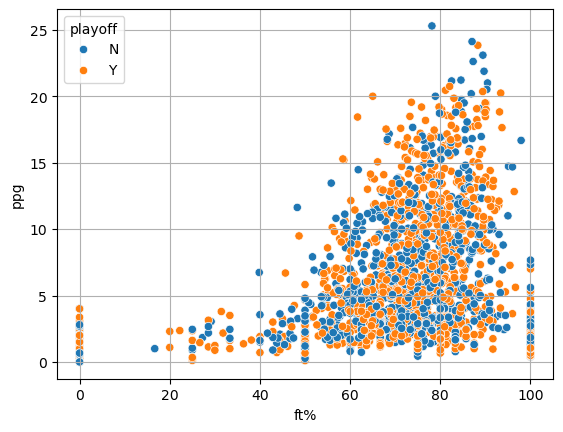

In [89]:
# Get the height of each player
player_height = players[['bioID', 'height']]

# Merge the player teams and player height dataframes (in the players_teams dataframe the id is playerID, in the players dataframe the id is bioID)
player_teams = player_teams.merge(player_height, left_on='playerID', right_on='bioID')

# Calculate points per minute
player_teams['ppg'] = player_teams['points'] / player_teams['GP']

#get the playoffs column from the teams dataframe, check by year and tmID
player_teams['playoff'] = player_teams.apply(
    lambda row: teams[teams['year'] == row['year']][teams['tmID'] == row['tmID']]['playoff'].values[0],
    axis=1
)

#remove outliers with height < 20

filtered_df = player_teams[player_teams['height'] > 20]

# Plot the scatter plot
sns.scatterplot(x='ft%', y='ppg', hue='playoff', data=filtered_df)
plt.grid(True)
plt.show()




     playerID                               award  year  next_season
0  thompti01w  All-Star Game Most Valuable Player     1            2
1  leslili01w  All-Star Game Most Valuable Player     2            3
2  leslili01w  All-Star Game Most Valuable Player     3            4
3  teaslni01w  All-Star Game Most Valuable Player     4            5
4  swoopsh01w  All-Star Game Most Valuable Player     6            7


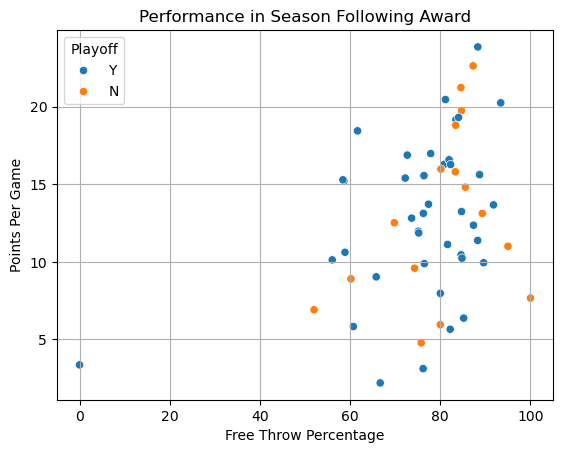

Percentage of players who won awards and made it to the playoffs the following year: 75.38%


In [92]:
# First, create a new column in 'awards_players' for the next season
awards_players['next_season'] = awards_players['year'] + 1

print(awards_players.head())

# Merge player_teams with awards_players on playerID and the next season
merged_df = player_teams.merge(awards_players[['playerID', 'award', 'next_season']], left_on=['playerID', 'year'], right_on=['playerID', 'next_season'])

# 2. Remove Outliers
filtered_df = merged_df[merged_df['height'] > 20]

# 3. Plot the scatter plot
sns.scatterplot(data=filtered_df, x='ft%', y='ppg', hue='playoff')
plt.title('Performance in Season Following Award')
plt.xlabel('Free Throw Percentage')
plt.ylabel('Points Per Game')
plt.grid(True)
plt.legend(title='Playoff')
plt.show()

#print the percentage of players who won awards and made it to the playoffs the following year
print('Percentage of players who won awards and made it to the playoffs the following year: {}%'.format(
    round(len(filtered_df[filtered_df['playoff'] == 'Y']) / len(filtered_df) * 100, 2)
))


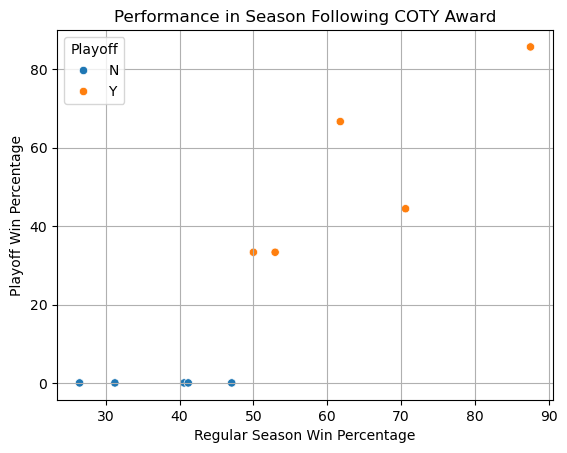

Percentage of coaches who won awards and made it to the playoffs the following year: 50.0%


In [98]:
#now do the same but for coaches, their awards are in the awards_players dataframe, but their teams are in the coaches dataframe and the playoffs are in the teams dataframe

# Merge coaches with awards_players on playerID and the next season, the playerID is coachID in the coaches dataframe
merged_df = coaches.merge(awards_players[['playerID', 'award', 'next_season']], left_on=['coachID', 'year'], right_on=['playerID', 'next_season'])

# 2. Remove Outliers
filtered_df = merged_df[merged_df['total_games'] > 0]

#get playoff column from teams dataframe
filtered_df['playoff'] = filtered_df.apply(
    lambda row: teams[teams['year'] == row['year']][teams['tmID'] == row['tmID']]['playoff'].values[0],
    axis=1
)

# 3. Plot the scatter plot
sns.scatterplot(data=filtered_df, x='W%', y='postW%', hue='playoff')
plt.title('Performance in Season Following COTY Award')
plt.xlabel('Regular Season Win Percentage')
plt.ylabel('Playoff Win Percentage')
plt.grid(True)
plt.legend(title='Playoff')
plt.show()

#print the percentage of coaches who won awards and made it to the playoffs the following year
print('Percentage of coaches who won awards and made it to the playoffs the following year: {}%'.format(
    round(len(filtered_df[filtered_df['playoff'] == 'Y']) / len(filtered_df) * 100, 2)
))

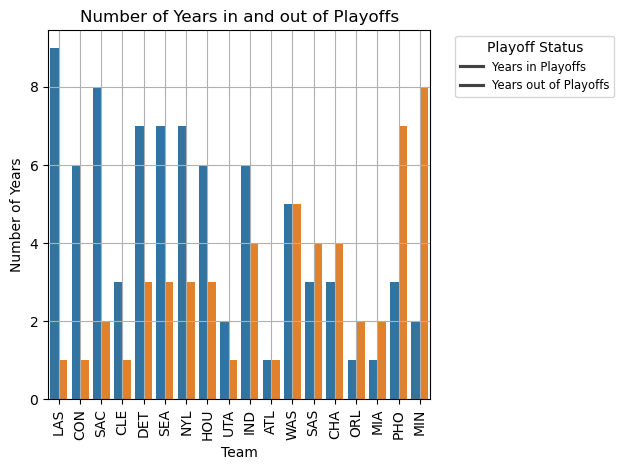

In [104]:
#plot a bar graph where x axis is the teams and y axis is the years they made it to the playoffs, make to bars per team, one for the number of years they did not make it to the playoffs and one for the number of years they did make it to the playoffs (you only need teams for this)

# Get the years each team made the playoffs
teams_playoffs = teams[teams['playoff'] == 'Y'].groupby('tmID').agg({
    'year': lambda x: list(x)
}).reset_index()

# Get the years each team did not make the playoffs

teams_no_playoffs = teams[teams['playoff'] == 'N'].groupby('tmID').agg({
    'year': lambda x: list(x)
}).reset_index()

# Get the number of years each team made the playoffs
teams_playoffs['num_years_playoffs'] = teams_playoffs['year'].apply(lambda x: len(x))

# Get the number of years each team did not make the playoffs
teams_no_playoffs['num_years_no_playoffs'] = teams_no_playoffs['year'].apply(lambda x: len(x))

# Merge the two dataframes
teams_merged = teams_playoffs.merge(teams_no_playoffs, on='tmID')

# Get the total number of years each team has been in the league
teams_merged['total_years'] = teams_merged['num_years_playoffs'] + teams_merged['num_years_no_playoffs']

# Get the percentage of years each team has made the playoffs
teams_merged['playoff_percentage'] = round((teams_merged['num_years_playoffs'] / teams_merged['total_years']) * 100, 2)

# Sort the values by playoff percentage
teams_merged.sort_values(by='playoff_percentage', ascending=False, inplace=True)

# Melt the data for plotting
teams_melted = pd.melt(teams_merged, id_vars='tmID', value_vars=['num_years_playoffs', 'num_years_no_playoffs'])
sns.barplot(data=teams_melted, x='tmID', y='value', hue='variable')
plt.title('Number of Years in and out of Playoffs')
plt.xlabel('Team')
plt.ylabel('Number of Years')
plt.grid(True)
plt.legend(title='Playoff Status', labels=['Years in Playoffs', 'Years out of Playoffs'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xticks(rotation=90)
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()

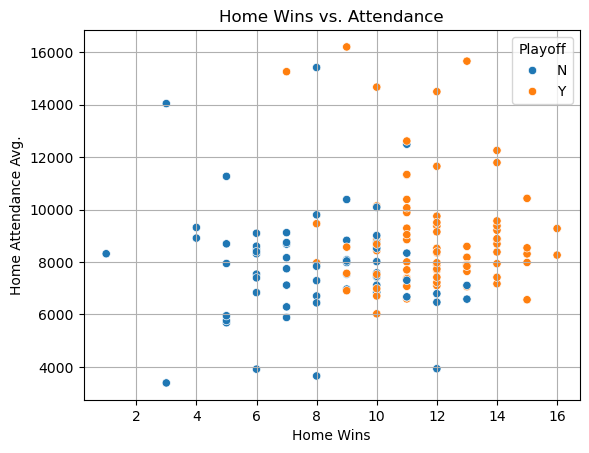

In [108]:
#plot a scatter graph for homeW in the x axis and attendance in the y axis, make the points different colors depending on the playoff column (you only need teams for this)

# Remove outliers
filtered_df = teams[teams['homeW'] > 0]

#get average attendance for each team
filtered_df['attend_avg'] = filtered_df.apply(
    lambda row: round((row['attend'] / (row['GP']-row['awayL']-row['awayW'])),2),
    axis=1
)

# Plot the scatter plot
sns.scatterplot(data=filtered_df, x='homeW', y='attend_avg', hue='playoff')
plt.title('Home Wins vs. Attendance')
plt.xlabel('Home Wins')
plt.ylabel('Home Attendance Avg.')
plt.grid(True)
plt.legend(title='Playoff')
plt.show()